## Loan-Prediction-Classifier 

We load a dataset using Pandas library, and apply the following algorithms, and find the best one for this specific dataset by accuracy evaluation methods.

Lets first load required libraries:

In [56]:
import itertools
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
import pandas as pd
import numpy as np
import matplotlib.ticker as ticker
from sklearn import preprocessing
%matplotlib inline

# About dataset

In [57]:
!wget -O loan_train.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv

--2022-05-03 10:25:08--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_train.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23101 (23K) [text/csv]
Saving to: ‘loan_train.csv’

loan_train.csv      100%[===================>]  22.56K  --.-KB/s    in 0.1s    

2022-05-03 10:25:08 (227 KB/s) - ‘loan_train.csv’ saved [23101/23101]



# Load Data From CSV File

In [58]:
df = pd.read_csv('loan_train.csv')
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,9/8/2016,10/7/2016,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,9/8/2016,10/7/2016,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,9/8/2016,9/22/2016,27,college,male
3,4,4,PAIDOFF,1000,30,9/9/2016,10/8/2016,28,college,female
4,6,6,PAIDOFF,1000,30,9/9/2016,10/8/2016,29,college,male


In [59]:
df.shape

(346, 10)

# Convert to date time object

In [63]:
df['due_date'] = pd.to_datetime(df['due_date'])
df['effective_date'] = pd.to_datetime(df['effective_date'])
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male


## Data visualization and pre-processing

Let’s see how many of each class is in our data set

In [64]:
df['loan_status'].value_counts()

PAIDOFF       260
COLLECTION     86
Name: loan_status, dtype: int64

260 people have paid off the loan on time while 86 have gone into collection

Lets plot some columns to underestand data better:

In [65]:
# notice: installing seaborn might takes a few minutes
!conda install -c anaconda seaborn -y

Solving environment: done

# All requested packages already installed.



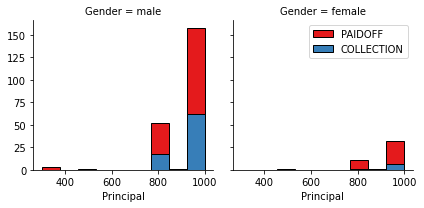

In [66]:
import seaborn as sns

bins = np.linspace(df.Principal.min(), df.Principal.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'Principal', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

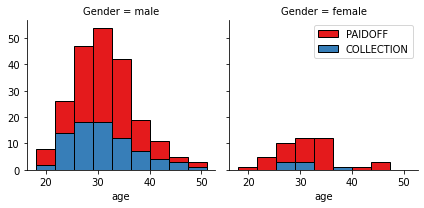

In [67]:
bins = np.linspace(df.age.min(), df.age.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'age', bins=bins, ec="k")

g.axes[-1].legend()
plt.show()

# Pre-processing: Feature selection/extraction
Lets look at the day of the week people get the loan

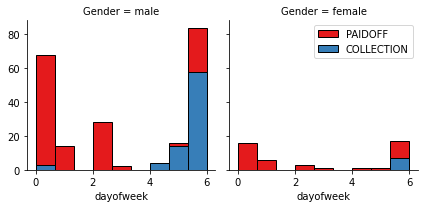

In [68]:
df['dayofweek'] = df['effective_date'].dt.dayofweek
bins = np.linspace(df.dayofweek.min(), df.dayofweek.max(), 10)
g = sns.FacetGrid(df, col="Gender", hue="loan_status", palette="Set1", col_wrap=2)
g.map(plt.hist, 'dayofweek', bins=bins, ec="k")
g.axes[-1].legend()
plt.show()

We see that people who get the loan at the end of the week dont pay it off, so lets use Feature binarization to set a threshold values less then day 4



In [69]:
df['weekend'] = df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,male,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,female,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,male,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,female,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,male,4,1


## Convert Categorical features to numerical values

Lets look at gender:

In [70]:
df.groupby(['Gender'])['loan_status'].value_counts(normalize=True)

Gender  loan_status
female  PAIDOFF        0.865385
        COLLECTION     0.134615
male    PAIDOFF        0.731293
        COLLECTION     0.268707
Name: loan_status, dtype: float64

86 % of female pay there loans while only 73 % of males pay there loan

Lets convert male to 0 and female to 1:

In [71]:
df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender,dayofweek,weekend
0,0,0,PAIDOFF,1000,30,2016-09-08,2016-10-07,45,High School or Below,0,3,0
1,2,2,PAIDOFF,1000,30,2016-09-08,2016-10-07,33,Bechalor,1,3,0
2,3,3,PAIDOFF,1000,15,2016-09-08,2016-09-22,27,college,0,3,0
3,4,4,PAIDOFF,1000,30,2016-09-09,2016-10-08,28,college,1,4,1
4,6,6,PAIDOFF,1000,30,2016-09-09,2016-10-08,29,college,0,4,1


# One Hot Encoding
How about education?

In [72]:
df.groupby(['education'])['loan_status'].value_counts(normalize=True)


education             loan_status
Bechalor              PAIDOFF        0.750000
                      COLLECTION     0.250000
High School or Below  PAIDOFF        0.741722
                      COLLECTION     0.258278
Master or Above       COLLECTION     0.500000
                      PAIDOFF        0.500000
college               PAIDOFF        0.765101
                      COLLECTION     0.234899
Name: loan_status, dtype: float64

# Feature before One Hot Encoding

In [73]:
df[['Principal','terms','age','Gender','education']].head()

,Principal,terms,age,Gender,education
0,1000,30,45,0,High School or Below
1,1000,30,33,1,Bechalor
2,1000,15,27,0,college
3,1000,30,28,1,college
4,1000,30,29,0,college


### Use one hot encoding technique to conver categorical varables to binary variables and append them to the feature Data Frame

In [37]:
Feature = df[['Principal','terms','age','Gender','weekend']]
Feature = pd.concat([Feature,pd.get_dummies(df['education'])], axis=1)
Feature.drop(['Master or Above'], axis = 1,inplace=True)
Feature.head()

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


In [74]:

X = Feature.iloc[:, :-1].values
print(X)

Y = Feature.iloc[:, -1].values
print(Y)

[[1000   30   45 ...    0    0    1]
 [1000   30   33 ...    0    1    0]
 [1000   15   27 ...    0    0    0]
 ...
 [ 800   15   39 ...    0    0    0]
 [1000   30   28 ...    0    0    0]
 [1000   30   26 ...    0    0    0]]
[0 0 1 1 1 1 1 1 1 0 1 1 0 1 0 0 0 1 1 0 1 0 0 0 1 1 0 1 1 1 1 0 0 1 1 0 1
 0 0 0 1 0 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 0 0 1 1 0 1 0 0 1 1 1 0 1 0 1
 0 0 0 1 1 0 0 1 1 0 1 0 0 1 1 1 1 1 1 1 0 1 0 0 1 1 0 1 1 1 1 0 0 0 0 0 0
 0 1 1 0 0 1 0 0 0 1 1 0 1 1 0 0 1 1 1 1 0 0 1 0 0 0 0 1 0 0 1 0 0 1 0 1 0
 1 0 1 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 1 1 0 1 0 1 1 0 1 1 0 0 0 0 0 0 0 1 0
 0 0 0 1 1 0 0 0 0 0 0 1 1 1 1 0 0 0 0 1 0 0 0 0 1 0 1 0 0 0 1 0 1 1 1 1 1
 0 1 0 1 0 0 0 0 0 1 0 1 1 0 0 1 0 1 1 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 1 0 0
 1 1 0 1 0 1 0 1 0 1 0 0 0 0 1 0 1 1 1 0 0 1 0 1 0 0 1 0 1 0 1 0 0 1 0 0 0
 0 0 1 0 1 0 0 0 1 0 0 1 0 1 0 0 1 1 0 0 0 1 1 0 0 1 0 1 1 1 1 0 0 0 0 0 0
 0 0 0 0 1 0 1 1 0 0 1 1 1]


In [76]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=4)

print("X_train size is ", X_train.shape, "\n", "X_test size is ", X_test.shape, "\n",
      "y_train size is ", y_train.shape, "\n", "y_test size is ", y_test.shape)
print(X_train[0:5])
y_train[0:5]

X_train size is  (276, 7) 
 X_test size is  (70, 7) 
 y_train size is  (276,) 
 y_test size is  (70,)
[[1000   15   35    0    0    0    0]
 [1000   30   26    0    1    0    1]
 [1000   30   31    0    0    0    0]
 [1000   15   25    0    1    0    0]
 [1000   30   28    0    0    0    0]]


array(['PAIDOFF', 'COLLECTION', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

## Feature selection
Lets defind feature sets, X:

In [77]:
X = Feature
X[0:5]

,Principal,terms,age,Gender,weekend,Bechalor,High School or Below,college
0,1000,30,45,0,0,0,1,0
1,1000,30,33,1,0,1,0,0
2,1000,15,27,0,0,0,0,1
3,1000,30,28,1,1,0,0,1
4,1000,30,29,0,1,0,0,1


What are our lables?

In [78]:
y = df['loan_status'].values
y[0:5]

array(['PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF', 'PAIDOFF'],
      dtype=object)

# Normalize Data
Data Standardization give data zero mean and unit variance (technically should be done after train test split )

In [79]:
X= preprocessing.StandardScaler().fit(X).transform(X)
X[0:5]

array([[ 0.51578458,  0.92071769,  2.33152555, -0.42056004, -1.20577805,
        -0.38170062,  1.13639374, -0.86968108],
       [ 0.51578458,  0.92071769,  0.34170148,  2.37778177, -1.20577805,
         2.61985426, -0.87997669, -0.86968108],
       [ 0.51578458, -0.95911111, -0.65321055, -0.42056004, -1.20577805,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.48739188,  2.37778177,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679],
       [ 0.51578458,  0.92071769, -0.3215732 , -0.42056004,  0.82934003,
        -0.38170062, -0.87997669,  1.14984679]])

In [80]:
X_train = preprocessing.StandardScaler().fit(X_train).transform(X_train.astype(float))
X_train[0:5]
X_test = preprocessing.StandardScaler().fit(X_test).transform(X_test.astype(float))
X_test[0:5]

array([[ 0.33474248,  0.83916906, -0.19614926, -0.47756693,  0.74535599,
        -0.2773501 ,  1.26197963],
       [-1.70282047, -0.9301633 , -0.19614926, -0.47756693,  0.74535599,
        -0.2773501 , -0.79240582],
       [ 0.33474248, -0.9301633 , -0.04012144, -0.47756693, -1.34164079,
        -0.2773501 ,  1.26197963],
       [ 0.33474248,  0.83916906, -1.13231619, -0.47756693, -1.34164079,
        -0.2773501 , -0.79240582],
       [ 0.33474248,  0.83916906,  0.42796202, -0.47756693, -1.34164079,
        -0.2773501 , -0.79240582]])

# Classification
Now, it is your turn, use the training set to build an accurate model. Then use the test set to report the accuracy of the model You should use the following algorithm:

K Nearest Neighbor(KNN)
Decision Tree
Support Vector Machine
Logistic Regression

### Notice:

You can go above and change the pre-processing, feature selection, feature-extraction, and so on, to make a better model.
You should use either scikit-learn, Scipy or Numpy libraries for developing the classification algorithms.
You should include the code of the algorithm in the following cells.

## K Nearest Neighbor(KNN)
Notice: You should find the best k to build the model with the best accuracy.
#### warning:  
You should not use the loan_test.csv for finding the best K, however, you can split your train_loan.csv into train and test to find the best k.

In [81]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import jaccard_score
import matplotlib.pyplot as plt
%matplotlib inline


Test set Accuracy at k= 1 :  0.520797902494331
Test set Accuracy at k= 2 :  0.516542404473439
Test set Accuracy at k= 3 :  0.6235377525700105
Test set Accuracy at k= 4 :  0.5204229232676677
Test set Accuracy at k= 5 :  0.5755208333333334
Test set Accuracy at k= 6 :  0.5640552995391706
Test set Accuracy at k= 7 :  0.6103896103896104
Test set Accuracy at k= 8 :  0.626530612244898
Test set Accuracy at k= 9 :  0.605239110569601


Text(0, 0.5, 'Testing Accuracy')

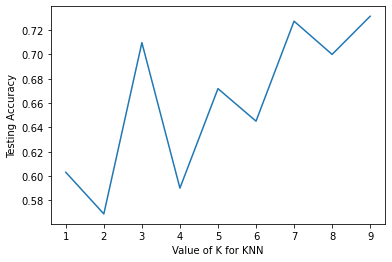

In [141]:
k_range = range(1, 10)
accuracy_score = []
for k in k_range:
    KNN = KNeighborsClassifier(n_neighbors = k).fit(X_train, y_train)
    # perform the test
    knn_yhat = KNN.predict(X_test)
    print("Test set Accuracy at k=", k, ": ", jaccard_score(y_test, knn_yhat,average='weighted'))
    accuracy_score.append(jaccard_score(y_test, knn_yhat,pos_label = "PAIDOFF"))

# plot the relationship between K and testing accuracy
plt.plot(k_range, accuracy_score)
plt.xlabel('Value of K for KNN')
plt.ylabel('Testing Accuracy')

In [162]:
#For KNN import library
from sklearn.neighbors import KNeighborsClassifier
# perform the test
KNN = KNeighborsClassifier(n_neighbors = 8).fit(X_train, y_train)
KNN

KNeighborsClassifier(n_neighbors=8)

## Decision Tree

In [160]:
# findinng the best depth level
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import f1_score
from sklearn.metrics import jaccard_score

# Compare accuracy result for depth = 3, 4 and 5
d_range = range(3, 6)
f1 = []
ja = []
for d in d_range:
    DT = DecisionTreeClassifier(criterion="entropy", max_depth=d)
    DT.fit(X_train, y_train)
    dt_yhat = DT.predict(X_test)
    f1.append(f1_score(y_test, dt_yhat,pos_label = "PAIDOFF"))
    ja.append(jaccard_score(y_test, dt_yhat,pos_label = "PAIDOFF"))

result = pd.DataFrame(f1, index=['d=3','d=4', 'd=5'])
result.columns = ['F1-score']
result.insert(loc=1, column='Jacard', value=ja)
result.columns.name = "Depth"
result

Depth,F1-score,Jacard
d=3,0.701031,0.539683
d=4,0.701031,0.539683
d=5,0.709677,0.550000


In [150]:
# for Decision Trees
from sklearn.tree import DecisionTreeClassifier
# prepare DT setting
DT = DecisionTreeClassifier(criterion="entropy", max_depth=5)
# perform the test
DT.fit(X_train, y_train)
DT

DecisionTreeClassifier(criterion='entropy', max_depth=5)

## Support Vector Machine

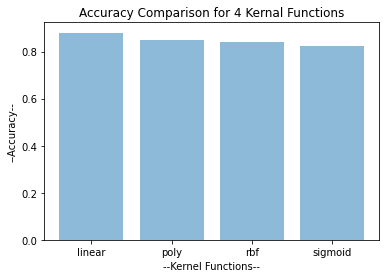

In [165]:
# for SVM
from sklearn import svm
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score

# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt
%matplotlib inline

func_list = ['linear', 'poly', 'rbf', 'sigmoid']
accuracy_score = []

for func in func_list:
    SVM = svm.SVC(kernel=func)
    SVM.fit(X_train, y_train)
    svm_yhat = SVM.predict(X_test)
    accuracy_score.append(f1_score(y_test, svm_yhat,pos_label = "PAIDOFF"))
    
# plot the comparison among 4 kernel functions
import numpy as np
import matplotlib.pyplot as plt
y_pos = np.arange(len(func_list))
plt.bar(y_pos, accuracy_score, align='center', alpha=0.5)
plt.xticks(y_pos, func_list)
plt.ylabel('--Accuracy--')
plt.xlabel('--Kernel Functions--')
plt.title('Accuracy Comparison for 4 Kernal Functions')
plt.show()

In [166]:
#For SVM import library
from sklearn import svm
# prepare SVM setting
SVM = svm.SVC(kernel='linear')
# perform the test
SVM.fit(X_train, y_train)
SVM

SVC(kernel='linear')

# Logistic Regression

Test  0 : Accuracy at c = 0.1 solver= newton-cg is :  0.47787783285324437
Test  1 : Accuracy at c = 0.1 solver= lbfgs is :  0.4778782520390756
Test  2 : Accuracy at c = 0.1 solver= liblinear is :  0.4913253985785426
Test  3 : Accuracy at c = 0.1 solver= sag is :  0.47786702413980425
Test  4 : Accuracy at c = 0.1 solver= saga is :  0.47788010183408847
Test  5 : Accuracy at c = 0.01 solver= newton-cg is :  0.4896163113042609
Test  6 : Accuracy at c = 0.01 solver= lbfgs is :  0.4896162822042322
Test  7 : Accuracy at c = 0.01 solver= liblinear is :  0.5702552695205898
Test  8 : Accuracy at c = 0.01 solver= sag is :  0.4896285920608317
Test  9 : Accuracy at c = 0.01 solver= saga is :  0.48961980190585996
Test  10 : Accuracy at c = 0.001 solver= newton-cg is :  0.51776791910729
Test  11 : Accuracy at c = 0.001 solver= lbfgs is :  0.5177678816389751
Test  12 : Accuracy at c = 0.001 solver= liblinear is :  0.669152490548167
Test  13 : Accuracy at c = 0.001 solver= sag is :  0.5177864354585195


Text(0, 0.5, 'Testing Accuracy')

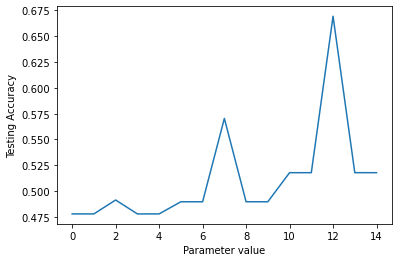

In [155]:
# for Logistic Regression
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import log_loss

# import Matplotlib (scientific plotting library)
import matplotlib.pyplot as plt
%matplotlib inline

c_list = [0.1, 0.01, 0.001]
solver_list = ['newton-cg', 'lbfgs', 'liblinear', 'sag', 'saga']
idx = []

accuracy_score = []
for idx1, c in enumerate(c_list):
    for idx2, sol in enumerate(solver_list):
        idx.append(idx2 + idx1 * 5)
        # perform the test
        LR = LogisticRegression(C=c, solver=sol).fit(X_train, y_train)
        # it can predict the outcome
        lr_yhat = LR.predict(X_test)
        lr_prob = LR.predict_proba(X_test)
        print("Test ", (idx2 + idx1 * 5), ": Accuracy at c =", c,"solver=", sol,
              "is : ", log_loss(y_test, lr_prob))
        accuracy_score.append(log_loss(y_test, lr_prob))
lr_prob = LR.predict_proba(X_test)
log_loss(y_test, lr_prob)
# plot the relationship between K and testing accuracy
plt.plot(idx, accuracy_score)
plt.xlabel('Parameter value')
plt.ylabel('Testing Accuracy')

In [156]:
from sklearn.linear_model import LogisticRegression
# prepare LR setting
LR = LogisticRegression(C=0.001, solver='liblinear').fit(X_train, y_train)
LR

LogisticRegression(C=0.001, solver='liblinear')

# Model Evaluation using Test set

In [127]:
from sklearn.metrics import jaccard_score
from sklearn.metrics import f1_score
from sklearn.metrics import log_loss

In [128]:
#downloading and loading dataset
!wget -O loan_test.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv

--2022-05-03 10:55:30--  https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/loan_test.csv
Resolving s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)... 67.228.254.196
Connecting to s3-api.us-geo.objectstorage.softlayer.net (s3-api.us-geo.objectstorage.softlayer.net)|67.228.254.196|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3642 (3.6K) [text/csv]
Saving to: ‘loan_test.csv’

loan_test.csv       100%[===================>]   3.56K  --.-KB/s    in 0s      

2022-05-03 10:55:31 (40.0 MB/s) - ‘loan_test.csv’ saved [3642/3642]



## Load Test Set for Evaluation

In [157]:
test_df = pd.read_csv('loan_test.csv')
test_df.head()

,Unnamed: 0,Unnamed: 0.1,loan_status,Principal,terms,effective_date,due_date,age,education,Gender
0,1,1,PAIDOFF,1000,30,9/8/2016,10/7/2016,50,Bechalor,female
1,5,5,PAIDOFF,300,7,9/9/2016,9/15/2016,35,Master or Above,male
2,21,21,PAIDOFF,1000,30,9/10/2016,10/9/2016,43,High School or Below,female
3,24,24,PAIDOFF,1000,30,9/10/2016,10/9/2016,26,college,male
4,35,35,PAIDOFF,800,15,9/11/2016,9/25/2016,29,Bechalor,male


In [169]:
test_df = pd.read_csv('loan_test.csv')
# convert date time
test_df['due_date'] = pd.to_datetime(test_df['due_date'])
test_df['effective_date'] = pd.to_datetime(test_df['effective_date'])
test_df['dayofweek'] = test_df['effective_date'].dt.dayofweek
# evaulate weekend field
test_df['weekend'] = test_df['dayofweek'].apply(lambda x: 1 if (x>3)  else 0)
# convert male to 0 and female to 1
test_df['Gender'].replace(to_replace=['male','female'], value=[0,1],inplace=True)
# work out education level
test_feature = test_df[['Principal','age','Gender','weekend']]
test_feature = pd.concat([test_feature,pd.get_dummies(test_df['education'])], axis=1)
test_feature.drop(['Master or Above'], axis = 1,inplace=True)
# Testing feature
X_loan_test = test_feature
# normalize the test data
X_loan_test = preprocessing.StandardScaler().fit(X_loan_test).transform(X_loan_test)
# and target result
y_loan_test = test_df['loan_status'].values
y_loan_test[0:5]
print (X_loan_test[0:5])
print (X_loan_test.shape)
print (y_loan_test[0:5])
print (y_loan_test.shape)

[[ 0.49362588  3.05981865  1.97714211 -1.30384048  2.39791576 -0.79772404
  -0.86135677]
 [-3.56269116  0.53336288 -0.50578054  0.76696499 -0.41702883 -0.79772404
  -0.86135677]
 [ 0.49362588  1.88080596  1.97714211  0.76696499 -0.41702883  1.25356634
  -0.86135677]
 [ 0.49362588 -0.98251057 -0.50578054  0.76696499 -0.41702883 -0.79772404
   1.16095912]
 [-0.66532184 -0.47721942 -0.50578054  0.76696499  2.39791576 -0.79772404
  -0.86135677]]
(54, 7)
['PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF' 'PAIDOFF']
(54,)


In [187]:
# Jaccard setup
from sklearn.metrics import jaccard_score

# evaluate KNN
knn_yhat = KNN.predict(X_loan_test)
jc1 = round(jaccard_score(y_loan_test, knn_yhat, pos_label = "PAIDOFF"), 2)
# evaluate Decision Trees
dt_yhat = DT.predict(X_loan_test)
jc2 = round(jaccard_score(y_loan_test, dt_yhat, pos_label = "PAIDOFF"), 2)
#evaluate SVM
svm_yhat = SVM.predict(X_loan_test)
jc3 = round(jaccard_score(y_loan_test, svm_yhat,pos_label = "PAIDOFF"), 2)
# evaluate Logistic Regression
lr_yhat = LR.predict(X_loan_test)
jc4 = round(jaccard_score(y_loan_test, lr_yhat,pos_label = "PAIDOFF"), 2)

list_jc = [jc1, jc2, jc3, jc4]
list_jc

[0.74, 0.63, 0.74, 0.59]

In [182]:
# F1-score setup
from sklearn.metrics import f1_score

# evaluate KNN
fs1 = round(f1_score(y_loan_test, knn_yhat,pos_label = "PAIDOFF"), 2)
# evaluate Desision Trees 
fs2 = round(f1_score(y_loan_test, dt_yhat, pos_label = "PAIDOFF"), 2)
# evaluate SVM
fs3 = round(f1_score(y_loan_test, svm_yhat, pos_label = "PAIDOFF"), 2)
# evaluate Logistic Regression
fs4 = round(f1_score(y_loan_test, lr_yhat, pos_label = "PAIDOFF"),2 )

list_fs = [fs1, fs2, fs3, fs4]
list_fs

[0.85, 0.77, 0.85, 0.74]

In [183]:
# LogLoss
from sklearn.metrics import log_loss
lr_prob = LR.predict_proba(X_loan_test)
list_ll = ['NA', 'NA', 'NA', round(log_loss(y_loan_test, lr_prob), 2)]
list_ll

['NA', 'NA', 'NA', 0.69]

In [184]:
import pandas as pd

# fomulate the report format
df = pd.DataFrame(list_jc, index=['KNN','Decision Tree','SVM','Logistic Regression'])
df.columns = ['Jaccard']
df.insert(loc=1, column='F1-score', value=list_fs)
df.insert(loc=2, column='LogLoss', value=list_ll)
df.columns.name = 'Algorithm'
df

Algorithm,Jaccard,F1-score,LogLoss
KNN,0.74,0.85,NA
Decision Tree,0.63,0.77,NA
SVM,0.74,0.85,NA
Logistic Regression,0.59,0.74,0.69
